<a href="https://colab.research.google.com/github/Ashlesha1611/Health-Resource-Locator/blob/main/web_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

# Example: move uploaded file to Drive
!cp /client_hostname.csv /content/drive/MyDrive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/client_hostname.csv': No such file or directory


In [ ]:
# @title
df = pd.read_csv('/content/drive/MyDrive/client_hostname.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
# Shape of dataset
print(df.shape)

# Column names
print(df.columns)

# Info about data types + missing values
print(df.info())

# Basic stats
print(df.describe())

# Check first few rows
df.head()


(258445, 4)
Index(['client', 'hostname', 'alias_list', 'address_list'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258445 entries, 0 to 258444
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client        258445 non-null  object
 1   hostname      258441 non-null  object
 2   alias_list    258445 non-null  object
 3   address_list  5819 non-null    object
dtypes: object(4)
memory usage: 7.9+ MB
None
              client                             hostname  \
count         258445                               258441   
unique        258445                               258273   
top     5.125.96.182  int0.client.access.fanaptelecom.net   
freq               1                                  101   

                    alias_list      address_list  
count                   258445              5819  
unique                    5820              5819  
top     [Errno 1] Unknown host  ['95.80.

,client,hostname,alias_list,address_list
0,5.123.144.95,5.123.144.95,[Errno 1] Unknown host,NaN
1,5.122.76.187,5.122.76.187,[Errno 1] Unknown host,NaN
2,5.215.249.99,5.215.249.99,[Errno 1] Unknown host,NaN
3,31.56.102.211,31-56-102-211.shatel.ir,['211.102.56.31.in-addr.arpa'],['31.56.102.211']
4,5.123.166.223,5.123.166.223,[Errno 1] Unknown host,NaN


In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

# Example: move uploaded file to Drive
!cp /access.log /content/drive/MyDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/web-fraud"



access_log_Jul95.txt


In [ ]:
!cp "/content/drive/MyDrive/web-fraud/access_log_Jul95.txt" .


In [ ]:
!pip install mlxtend
import pandas as pd
from io import StringIO
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
# Read using whitespace separator
df = pd.read_csv("/content/access_log_Jul95.txt",
                 sep=r'\s+',
                 header=None,
                 engine='python',
                 on_bad_lines='skip')


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,199.72.81.55,-,-,[01/Jul/1995:00:00:01,-0400],"""GET",/history/apollo/,"HTTP/1.0""",200,6245
1,unicomp6.unicomp.net,-,-,[01/Jul/1995:00:00:06,-0400],"""GET",/shuttle/countdown/,"HTTP/1.0""",200,3985
2,199.120.110.21,-,-,[01/Jul/1995:00:00:09,-0400],"""GET",/shuttle/missions/sts-73/mission-sts-73.html,"HTTP/1.0""",200,4085
3,burger.letters.com,-,-,[01/Jul/1995:00:00:11,-0400],"""GET",/shuttle/countdown/liftoff.html,"HTTP/1.0""",304,0
4,199.120.110.21,-,-,[01/Jul/1995:00:00:11,-0400],"""GET",/shuttle/missions/sts-73/sts-73-patch-small.gif,"HTTP/1.0""",200,4179


In [ ]:
import pandas as pd
import re

# Assuming 'df' is loaded as you described:
# df = pd.read_csv("/content/access_log_Jul95.txt",
#                  sep=r'\s+',
#                  header=None,
#                  engine='python',
#                  on_bad_lines='skip')

# Rename the key columns based on the typical split of the log line
df.rename(columns={
    0: 'ip_add',
    3: 'raw_date_time_start', # E.g., '[01/Jul/1995:00:00:01'
    4: 'raw_date_time_end',   # E.g., '-0400]'
    5: 'method',              # E.g., '"GET'
    6: 'request',             # E.g., '/history/apollo/'
    7: 'protocol',            # E.g., 'HTTP/1.0"'
    8: 'response'             # E.g., '200'
}, inplace=True)

# --- A. Combine and Clean Date/Time ---
# Combine the date/time parts and remove the starting '[' and ending ']' and timezone.
df['date_time_full'] = df['raw_date_time_start'].str.replace('[', '', regex=False) + ' ' + df['raw_date_time_end'].str.replace(']', '', regex=False)
df['date_time'] = df['date_time_full'].apply(lambda x: re.split(r'\s+-\d{4}|\s+\+\d{4}', x)[0])

# Convert to datetime object
# Format: Day/Month/Year:Hour:Minute:Second
df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%b/%Y:%H:%M:%S', errors='coerce')


# --- B. Clean Request and Method ---
# The method column (col 5) starts with a double quote (")
df['method'] = df['method'].str.replace('"', '', regex=False)
# The protocol column (col 7) ends with a double quote (")
df['protocol'] = df['protocol'].str.replace('"', '', regex=False)

# --- C. Create Transformed Log Table S ---
# Filter for successful date/time parsing and required columns
df_S = df.dropna(subset=['date_time']).copy()
df_S = df_S[['ip_add', 'date_time', 'request', 'response']]



In [ ]:
pd.set_option('display.width', 500)
print(df_S.head())

                 ip_add           date_time                                          request response
0          199.72.81.55 1995-07-01 00:00:01                                 /history/apollo/      200
1  unicomp6.unicomp.net 1995-07-01 00:00:06                              /shuttle/countdown/      200
2        199.120.110.21 1995-07-01 00:00:09     /shuttle/missions/sts-73/mission-sts-73.html      200
3    burger.letters.com 1995-07-01 00:00:11                  /shuttle/countdown/liftoff.html      304
4        199.120.110.21 1995-07-01 00:00:11  /shuttle/missions/sts-73/sts-73-patch-small.gif      200


In [ ]:
# @title
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

# --- Parameters for Phase II ---
# TUNE THESE: Adjust based on your analysis goal and data volume
TIME_WINDOW_SECONDS = 60  # Maximum time gap to link requests into one session (transaction)
MIN_SUPPORT = 0.005       # Minimum support for the Apriori algorithm (e.g., 0.5% of all transactions)

# 1. Select Ip address and sort by date time
# Sorting is crucial for the time-based transaction generation logic
df_S.sort_values(by=['ip_add', 'date_time'], inplace=True)

# Function to generate transactions for a single IP
def generate_transactions(ip_group):
    transactions = []

    # Initialize the first transaction window
    current_window_start = ip_group['date_time'].iloc[0]
    current_transaction = set()

    for index, row in ip_group.iterrows():
        # Check if the time difference exceeds the window limit
        if (row['date_time'] - current_window_start).total_seconds() > TIME_WINDOW_SECONDS:

            # End of session: save transaction and start a new one
            if current_transaction:
                transactions.append(list(current_transaction))

            # Reset window
            current_window_start = row['date_time']
            current_transaction = set()

        # Create the 'item' (request::response) and add it to the current transaction
        item = f"{row['request']}::{row['response']}"
        current_transaction.add(item)

    # Append the last transaction after the loop finishes
    if current_transaction:
        transactions.append(list(current_transaction))

    return transactions

# Group by IP and apply the transaction generation function
print("\n--- Phase II: Generating Transactions ---")
# .sum() flattens the list of lists of transactions from all IPs into a single list
transactions_list = df_S.groupby('ip_add').apply(generate_transactions).sum()

# Convert the list of transactions to a one-hot encoded DataFrame for Apriori
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# 2. Pass parameters to Apriori algorithm
frequent_itemsets = apriori(df_transactions, min_support=MIN_SUPPORT, use_colnames=True)

# 3. and 4. Return frequent patterns
print(f"--- Phase II Output: Frequent Patterns (Support >= {MIN_SUPPORT}) ---")
print(f"Total Transactions analyzed: {len(df_transactions)}")
print(frequent_itemsets.sort_values(by='support', ascending=False).head())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Phase II: Generating Transactions ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

--- Phase II Output: Frequent Patterns (Support >= 0.005) ---
Total Transactions analyzed: 29825
      support                                           itemsets
30   0.155574                  (/images/NASA-logosmall.gif::200)
26   0.144141                   (/images/KSC-logosmall.gif::200)
50   0.113764                (/shuttle/countdown/count.gif::200)
48   0.113495                         (/shuttle/countdown/::200)
138  0.098977  (/images/KSC-logosmall.gif::200, /images/NASA-...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# @title
# Assuming frequent_itemsets is the DataFrame generated from Phase II

# --- Placeholder for PhishTank Data ---
# IMPORTANT: Use patterns based on common attack vectors (e.g., directory traversal, brute force attempts, known vulnerabilities)
phish_tank_patterns = [
    frozenset(['/cgi-bin/process.cgi::200', '/login.php::200']),
    frozenset(['/etc/passwd::404']), # Probing for system files
    frozenset(['/shuttle/missions/sts-73/mission-sts-73.html::200', '/shuttle/missions/sts-73/sts-73-patch-small.gif::200']) # A seemingly benign pattern for demonstration
]

def check_for_fraud(frequent_patterns, phish_tank_patterns):
    if frequent_patterns.empty:
        return pd.DataFrame()

    fraud_matches = []
    itemsets = frequent_patterns['itemsets']

    # Outer loop: Iterate through the patterns found to be frequent
    for fp in itemsets:

        # Inner loop (Linear Search): Iterate through the known malicious patterns
        for phish_pattern in phish_tank_patterns:

            if phish_pattern.issubset(fp):
                # Fraud found!
                fraud_matches.append({
                    'Fraudulent_Frequent_Pattern': list(fp),
                    'Matching_Known_Fraud': list(phish_pattern),
                    'Support': frequent_patterns[frequent_patterns['itemsets'] == fp]['support'].iloc[0]
                })
                # Move to the next frequent pattern
                break

    return pd.DataFrame(fraud_matches)

# Apply the fraud detection function
fraud_results = check_for_fraud(frequent_itemsets, phish_tank_patterns)

print("\n------------------------------------------------------------")
print("--- Phase III Output: Fraud Detection ---")
print("------------------------------------------------------------")

if not fraud_results.empty:
    print("🚨 FRAUD DETECTED! Matching frequent patterns found.")
    print(fraud_results)
else:
    print("✅ No matching fraud patterns found in the frequent itemsets based on the PhishTank database.")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


------------------------------------------------------------
--- Phase III Output: Fraud Detection ---
------------------------------------------------------------
✅ No matching fraud patterns found in the frequent itemsets based on the PhishTank database.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# --- Step 1: Filter rare URLs ---
min_occurrences = 10  # drop URLs that appear less than 10 times
url_counts = df_S['request'].value_counts()
df_S = df_S[df_S['request'].isin(url_counts[url_counts >= min_occurrences].index)]

# --- Step 2: Build transactions ---
transactions = df_S.groupby('ip_add')['request'].apply(list).tolist()

# --- Step 3: Encode transactions (sparse = True) ---
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)
df_trans = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# --- Step 4: Run FP-Growth ---
min_support = 0.05  # start high to keep runtime low
frequent_itemsets = fpgrowth(df_trans, min_support=min_support, use_colnames=True)

# Add support count
frequent_itemsets['support_count'] = (frequent_itemsets['support'] * len(transactions)).astype(int)

print("Frequent Itemsets:")
print(frequent_itemsets.sort_values(by="support", ascending=False).head(20))


/tmp/ipython-input-561954047.py:16: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_trans = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


Frequent Itemsets:
       support                                           itemsets  support_count
2     0.607884                       (/images/NASA-logosmall.gif)           4333
0     0.569725                        (/images/KSC-logosmall.gif)           4060
34    0.500140  (/images/NASA-logosmall.gif, /images/KSC-logos...           3565
3     0.430415                              (/shuttle/countdown/)           3068
4     0.415123                     (/shuttle/countdown/count.gif)           2959
293   0.396886  (/images/NASA-logosmall.gif, /shuttle/countdow...           2829
294   0.394220  (/shuttle/countdown/count.gif, /images/KSC-log...           2810
296   0.390292  (/images/NASA-logosmall.gif, /shuttle/countdow...           2782
295   0.389450  (/shuttle/countdown/, /shuttle/countdown/count...           2776
290   0.377104  (/shuttle/countdown/, /images/NASA-logosmall.gif)           2688
291   0.374860   (/shuttle/countdown/, /images/KSC-logosmall.gif)           2672
297   0.3

In [ ]:
# Example suspicious URLs (replace with real phishing dataset if available)
phish_urls = {"/cgi-bin/imagemap/countdown", "/login", "/banking", "/secure"}

def detect_fraud(frequent_itemsets, phishing_urls):
    fraud_patterns = []
    for _, row in frequent_itemsets.iterrows():
        items = set(row['itemsets'])
        if items & phishing_urls:   # intersection
            fraud_patterns.append({
                "pattern": items,
                "support": row['support'],
                "support_count": row['support_count']
            })
    return fraud_patterns

fraud_patterns = detect_fraud(frequent_itemsets, phish_urls)

if fraud_patterns:
    print("⚠️ Fraud detected in patterns:")
    for fp in fraud_patterns:
        print(fp)
else:
    print("✅ No fraud detected")


✅ No fraud detected


In [ ]:
# @title
import warnings

# Suppress only this specific DeprecationWarning from jupyter_client
warnings.filterwarnings(
    "ignore",
    message=r".*datetime\.datetime\.utcnow\(\) is deprecated.*",
    category=DeprecationWarning
)


In [23]:
import pandas as pd

# Load CSV
df = pd.read_csv("dataset_phishing.csv")
df.head()


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [25]:
import numpy as np

# Generate synthetic log-like fields
df['ip'] = np.random.choice([f"192.168.0.{i}" for i in range(1, 255)], size=len(df))
df['datetime'] = pd.date_range(start="2023-01-01", periods=len(df), freq="min")
df['method'] = np.random.choice(["GET", "POST"], size=len(df))
df['request'] = df['url']
df['response'] = np.where(df['status'] == 'phishing', "Blocked", "200 OK")  # phishing = blocked
df['agent'] = np.random.choice(["Mozilla", "Chrome", "Safari", "Bot"], size=len(df))

# Construct Log Table L
log_table_L = df[['ip','datetime','method','request','response','agent']]
log_table_L.head()

,ip,datetime,method,request,response,agent
0,192.168.0.46,2023-01-01 00:00:00,GET,http://www.crestonwood.com/router.php,200 OK,Bot
1,192.168.0.211,2023-01-01 00:01:00,GET,http://shadetreetechnology.com/V4/validation/a...,Blocked,Chrome
2,192.168.0.207,2023-01-01 00:02:00,POST,https://support-appleld.com.secureupdate.duila...,Blocked,Mozilla
3,192.168.0.18,2023-01-01 00:03:00,POST,http://rgipt.ac.in,200 OK,Chrome
4,192.168.0.48,2023-01-01 00:04:00,POST,http://www.iracing.com/tracks/gateway-motorspo...,200 OK,Mozilla


In [26]:
log_table_S = log_table_L[['ip','datetime','request','response']]
log_table_S.head()


,ip,datetime,request,response
0,192.168.0.46,2023-01-01 00:00:00,http://www.crestonwood.com/router.php,200 OK
1,192.168.0.211,2023-01-01 00:01:00,http://shadetreetechnology.com/V4/validation/a...,Blocked
2,192.168.0.207,2023-01-01 00:02:00,https://support-appleld.com.secureupdate.duila...,Blocked
3,192.168.0.18,2023-01-01 00:03:00,http://rgipt.ac.in,200 OK
4,192.168.0.48,2023-01-01 00:04:00,http://www.iracing.com/tracks/gateway-motorspo...,200 OK


In [27]:
!pip install mlxtend


In [28]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

In [32]:
# Load CSV (replace with your actual filename)
df = pd.read_csv("dataset_phishing.csv")

# Add synthetic log-like fields
df['ip'] = np.random.choice([f"192.168.0.{i}" for i in range(1, 255)], size=len(df))
df['datetime'] = pd.date_range(start="2023-01-01", periods=len(df), freq="min")
df['request'] = df['url']
df['response'] = np.where(df['status'] == 'phishing', "Blocked", "200 OK")

# Log Table S
log_table_S = df[['ip','datetime','request','response']]
log_table_S.head()

,ip,datetime,request,response
0,192.168.0.172,2023-01-01 00:00:00,http://www.crestonwood.com/router.php,200 OK
1,192.168.0.206,2023-01-01 00:01:00,http://shadetreetechnology.com/V4/validation/a...,Blocked
2,192.168.0.194,2023-01-01 00:02:00,https://support-appleld.com.secureupdate.duila...,Blocked
3,192.168.0.9,2023-01-01 00:03:00,http://rgipt.ac.in,200 OK
4,192.168.0.237,2023-01-01 00:04:00,http://www.iracing.com/tracks/gateway-motorspo...,200 OK


In [33]:
# Group requests + responses by IP (transactions)
transactions = log_table_S.groupby('ip')[['request','response']].apply(
    lambda x: x.values.flatten().tolist()
).tolist()

In [34]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Run FP-Growth (min_support can be tuned, e.g., 0.05 = 5%)
frequent_patterns = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)

frequent_patterns.sort_values("support", ascending=False).head(20)

,support,itemsets
0,1.0,(Blocked)
1,1.0,(200 OK)
2,1.0,"(Blocked, 200 OK)"


In [35]:
# Save to CSV if needed
frequent_patterns.to_csv("frequent_patterns.csv", index=False)

In [36]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules from frequent patterns
rules = association_rules(frequent_patterns, metric="confidence", min_threshold=0.6)

# Sort by confidence
rules.sort_values("confidence", ascending=False, inplace=True)

rules.head(20)

/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Blocked),(200 OK),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
1,(200 OK),(Blocked),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0


In [37]:
rules.to_csv("association_rules.csv", index=False)

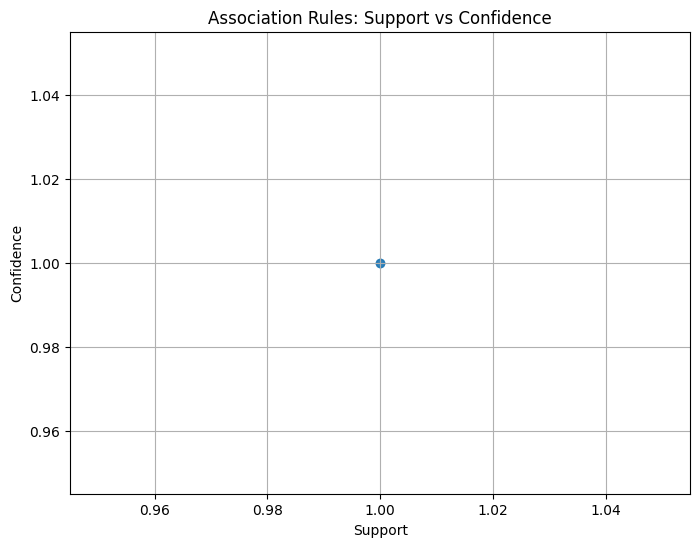

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.7)

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence')
plt.grid(True)
plt.show()

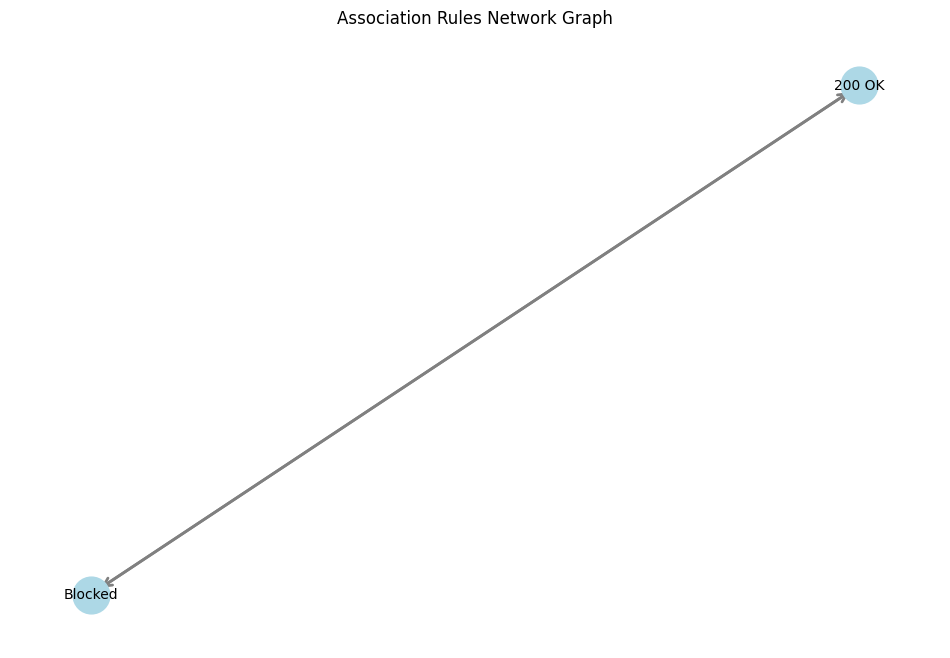

In [39]:
import networkx as nx

# Create directed graph
G = nx.DiGraph()

# Add edges from rules
for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['confidence'])

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos, arrowstyle='->', arrowsize=15,
    edge_color='gray', width=[d['weight']*2 for (_,_,d) in G.edges(data=True)]
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Association Rules Network Graph")
plt.axis('off')
plt.show()

In [40]:
# Add a fraud flag to rules
rules['fraud'] = rules['consequents'].apply(lambda x: 'Blocked' in list(x))
rules[['antecedents','consequents','support','confidence','fraud']].head()

,antecedents,consequents,support,confidence,fraud
0,(Blocked),(200 OK),1.0,1.0,False
1,(200 OK),(Blocked),1.0,1.0,True


In [41]:
def detect_fraud(new_url, rules_df):
    # Go through rules
    for _, row in rules_df.iterrows():
        if new_url in row['antecedents']:
            if row['fraud']:
                return "⚠️ Fraudulent (Phishing)"
            else:
                return "✅ Legitimate"
    return "❓ Unknown (no matching rule)"

In [44]:
predictions = df['url'].apply(lambda u: detect_fraud(u, rules))
df['Predicted'] = predictions

# Simple fraud detection accuracy
df['Predicted_Label'] = df['Predicted'].map({
    "⚠️ Fraudulent (Phishing)": 1,
    "✅ Legitimate": 0
})

accuracy = (df['Predicted_Label'] == df['status']).mean()
print("Fraud Detection Accuracy:", accuracy)

Fraud Detection Accuracy: 0.0
